# Odometry Reconstruction Accuracy Results

 * **Warning:** quite a bit of copypasta from the 'DepthAnalysis' notebook.

In [32]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

import os
import sys

%matplotlib inline

from matplotlib import rc

# Enables full LaTeX support in the plot text.
# Requires a full-fledged LaTeX installation on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 5)
matplotlib.rcParams.update({'font.size': 20})

In [51]:
INNER_GAP = 0.75
SEQUENCE_GAP = 1.0

sequences = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
metrics = ['input', 'fusion']
depths = ['elas', 'dispnet']

GROUP_SIZE = len(depths) * len(metrics)


def compute_metrics(dataframe, metric):
    # Do not count frames with no pixels in them. This would distort the 
    # dynamic reconstruction metrics due to frames containing no objects.
    ok = (dataframe['{}-total-3.00-kitti'.format(metric)] != 0)

    err = dataframe['{}-error-3.00-kitti'.format(metric)][ok]
    tot = dataframe['{}-total-3.00-kitti'.format(metric)][ok]
    mis = dataframe['{}-missing-3.00-kitti'.format(metric)][ok]
    cor = dataframe['{}-correct-3.00-kitti'.format(metric)][ok]
    mis_sep = dataframe['{}-missing-separate-3.00-kitti'.format(metric)][ok]

    acc_perc = cor / (tot - mis)
    completeness = 1.0 - (mis_sep / tot)

    return acc_perc, completeness


def load_logs(fpath_fmt, part):
    frames = {}
    for sequence_id in sequences:
        for depth in depths:
            fname = fpath_fmt.format(sequence_id=sequence_id, depth=depth, part=part)
            df = pd.read_csv(fname)
            frames[(depth, sequence_id)] = df
    return frames


def load_and_preprocess(fpath_fmt, part, colors):
    """Loads the data and prepares some positioning and color info.
    
    Since we're doing a nontrivial plot, which means we need to do a lot of
    stuff manually.
    
    Args:
        fpath_fmt: Format string for the CSV paths to load.
        part:      Dictates what we are evaluating: dynamic or static parts
        colors:    Nested array with plot color info.
                   (colors[method][input/fusion] = color_name)
    """
    box_colors = []
    box_positions = []
    columns = []

    box_offset = 0
    # Aggregated for all the sequences.
    res_acc_agg = {}
    res_completeness_agg = {}
    res = {}
    res_completeness = {}
    
    data = load_logs(fpath_fmt, part)
    
    for sequence_id in sequences:
        for depth in depths:
            df = data[(depth, sequence_id)]
            
            for metric in metrics:
                key = "{}-{}-{:02d}".format(metric, depth, sequence_id)
                agg_key = "{}-{}".format(metric, depth)
                if not agg_key in res_acc_agg:
                    res_acc_agg[agg_key] = []
                    res_completeness_agg[agg_key] = []
                
                acc_perc, completeness = compute_metrics(df, metric)
                res[key] = acc_perc
                res_completeness[key] = completeness
                res_acc_agg[agg_key] = res_acc_agg[agg_key] + acc_perc.tolist()
                res_completeness_agg[agg_key] = res_completeness_agg[agg_key] + completeness.tolist()
                
                box_colors.append(colors[depth][metric])
                
                columns.append(key)
                box_positions.append(box_offset)
                box_offset += INNER_GAP
            
        box_offset += SEQUENCE_GAP
        
    return res, res_completeness, res_acc_agg, res_completeness_agg, box_offset, box_colors, box_positions, columns


def setup_agg_plot(ax, boxplot, fill=False):
        # Aesthetic crap
        ax.set_ylim([0.4, 1.01])
#         plt.minorticks_()
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))
        plt.xticks(rotation=45, ha='right')
        colors = ['C0', 'C1', 'C2', 'C3']

        for i, patch in enumerate(boxplot['medians']):
            if fill:
                patch.set_color('black')
            else:
                patch.set_color(colors[i])
        for i, patch in enumerate(boxplot['boxes']):
            if fill:
                patch.set_color('black')
                patch.set_facecolor(colors[i])
            else:
                patch.set_color(colors[i])
                
        for i, patch in enumerate(boxplot['whiskers']):
            if fill:
                patch.set_color('black')
            else:
                patch.set_color(colors[i//2])
        for i, patch in enumerate(boxplot['caps']):
            if fill:
                patch.set_color('black')
            else:
                patch.set_color(colors[i//2])

        ax.set_xticklabels(["ELAS input", "ELAS fused", "DispNet input", "DispNet fused"])
        ax.grid('off')
        ax.yaxis.grid(True, linestyle='-', which='major', color='gray', alpha=0.75)
        ax.yaxis.grid(True, linestyle='-', which='minor', color='lightgrey', alpha=0.75)

Data read & aggregated OK.
Agg meta-stats:
input-elas 22788
input-dispnet 22788
fusion-dispnet 22788
fusion-elas 22788
Textual results: 
input-elas : 0.9101852172474811
fusion-elas : 0.9156700929357738
input-dispnet : 0.8947140885497985
fusion-dispnet : 0.8898074020656355
Saved figure to [odo-acc-agg-static-depth-result].    
Textual results: 
input-elas : 0.7941609872954063
fusion-elas : 0.9378335076194251
input-dispnet : 0.989920269352067
fusion-dispnet : 0.9780469902068254
Saved figure to [odo-completeness-agg-static-depth-result].    
Data read & aggregated OK.
Agg meta-stats:
input-elas 12074
input-dispnet 12074
fusion-dispnet 12074
fusion-elas 12074
Textual results: 
input-elas : 0.8414992272906736
fusion-elas : 0.8157548800911882
input-dispnet : 0.8621201951441085
fusion-dispnet : 0.8290028455484645
Saved figure to [odo-acc-agg-dynamic-depth-result].    
Textual results: 
input-elas : 0.8650405140215749
fusion-elas : 0.9470498466719215
input-dispnet : 0.9890199622179487
fusion-d

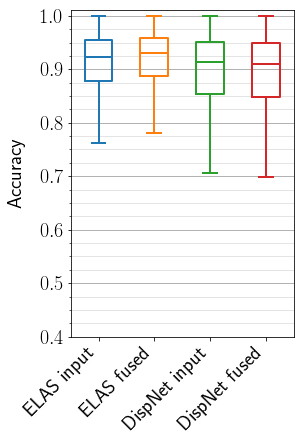

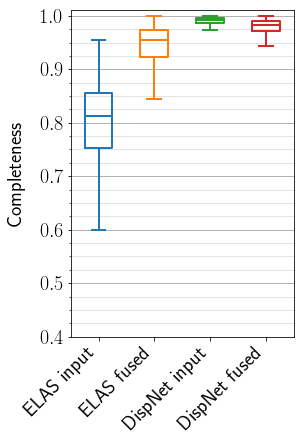

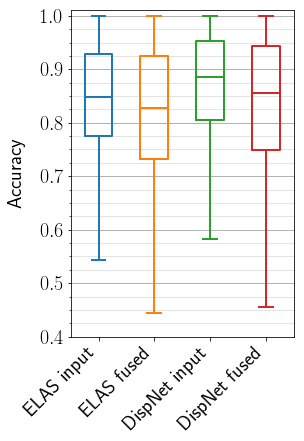

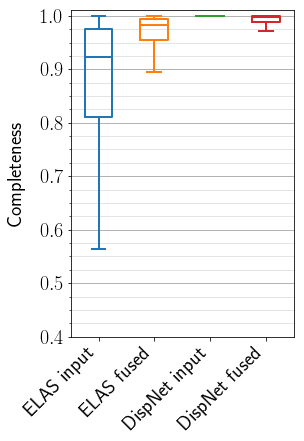

In [62]:
def gen_plots(root, part, out_dir, **kw):
    file_pattern = 'k-99999-kitti-odometry-{sequence_id:02d}-offset-0-depth-precomputed-{depth}-' \
                   'voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-' \
                   'with-fusion-weights-{part}.csv'
    base = os.path.join(root, file_pattern)
    save_to_disk = kw.get('save_to_disk', True)
    
    # Controls which plots are produced
    plot_agg = True
    plot_separate = False
        
    colors = {
        'elas': {
            'input': 'C0',
            'fusion': 'C1',
        },
        'dispnet': {
            'input': 'C2',
            'fusion': 'C3'
        }
    }
    
    def setup_xaxis_legend(ax, **kw):
        bp_np = np.array(box_positions)
        alt_ticks = bp_np[np.arange(len(bp_np)) % GROUP_SIZE == 0] + (INNER_GAP*(GROUP_SIZE-1.0)/2.0)
        ax.set_xticks(alt_ticks)
        ax.set_xticklabels("{:02d}".format(sid) for sid in sequences)
        ax.set_xlabel("Sequence")

        ax.set_ylim([0.0, 1.0])

        for patch, color in zip(boxplot['medians'], box_colors):
            patch.set_color(color)    

        for patch, color in zip(boxplot['boxes'], box_colors):
            patch.set_color(color)

        # Ugly, but required since every box has two whiskers and two caps...
        for idx, (whisker, cap) in enumerate(zip(boxplot['whiskers'], boxplot['caps'])):
            cap.set_color(box_colors[idx%(2*GROUP_SIZE) // 2])
            whisker.set_color(box_colors[idx%(2*GROUP_SIZE) // 2])   

        # Dummies for showing the appropriate legend
        ax.plot([0.0], [-1000], label="ELAS input", color=colors['elas']['input'])
        ax.plot([0.0], [-1000], label="ELAS fused", color=colors['elas']['fusion'])
        ax.plot([0.0], [-1000], label="DispNet input", color=colors['dispnet']['input'])
        ax.plot([0.0], [-1000], label="DispNet fused", color=colors['dispnet']['fusion'])
        ax.legend(loc=kw.get('legendloc', 'lower left'))

        ax.grid('off')
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)
        
    def save_fig(f, fname):
        print("Saving figure to [{}]... ".format(fname), end='')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        f.savefig(os.path.join(out_dir, fname + '.png'), bbox_inches='tight')
        f.savefig(os.path.join(out_dir, fname + '.eps'), bbox_inches='tight')
        print("\rSaved figure to [{}].    ".format(fname))
    
    res, res_completeness, res_acc_agg, res_completeness_agg, box_offset, box_colors, box_positions, columns = \
        load_and_preprocess(base, part, colors)
                
#     res_acc_all = [entry for (key, sublist) in res.items() for entry in sublist]
        
    print("Data read & aggregated OK.")
    print("Agg meta-stats:")
    for k, v in res_acc_agg.items():
        print(k, len(v))
        
    agg_props = {'linewidth': 2}
    
    ################################################################################
    # Accuracy plots
    ################################################################################
    if plot_separate:
        res_df = pd.DataFrame(res)    
        FIG_SIZE = (16, 6)
        fig = plt.figure(figsize=FIG_SIZE)
        ax = fig.add_subplot(1, 1, 1)
        (ax, boxplot) = res_df.boxplot(columns, showfliers=False, 
                                       return_type='both',
                                       widths=0.50, 
                                       ax=ax, 
    #                                    patch_artist=True,  # Enable fill
                                       positions=box_positions)
        setup_xaxis_legend(ax)
        ax.set_ylabel("Accuracy", labelpad=15)
        ax.set_ylim([0.3, 1.01])
        if save_to_disk:
            save_fig(fig, 'odo-acc-{}'.format(part))
    
    ################################################################################
    # Aggregate accuracy plots
    ################################################################################
    if plot_agg:
        res_acc_agg_df = pd.DataFrame(res_acc_agg)
        fig = plt.figure(figsize=(4,6))
        ax = fig.add_subplot(1, 1, 1)
        agg_cols = ['input-elas', 'fusion-elas', 'input-dispnet', 'fusion-dispnet']
        (ax, boxplot) = res_acc_agg_df.boxplot(agg_cols, showfliers=False,
                                               return_type='both',
                                               widths=0.50,
                                               ax=ax,
                                               boxprops=agg_props,
                                               whiskerprops=agg_props,
                                               capprops=agg_props,
                                               medianprops=agg_props)
    #                                            patch_artist=True)
        ax.set_ylabel("Accuracy", labelpad=15)
        setup_agg_plot(ax, boxplot)

        print("Textual results: ")
        for col in agg_cols:
            print(col, ":", res_acc_agg_df[col].mean())

        if save_to_disk:
            save_fig(fig, 'odo-acc-agg-{}'.format(part))
    
    ################################################################################
    # Completeness plots
    ################################################################################
    if plot_separate:
        res_completeness_df = pd.DataFrame(res_completeness)
        fig = plt.figure(figsize=FIG_SIZE)
        ax = fig.add_subplot(1, 1, 1)

        (ax, boxplot) = res_completeness_df.boxplot(columns, showfliers=False, 
                                                   return_type='both',
                                                   widths=0.50, 
                                                   ax=ax, 
                #                                    patch_artist=True,  # Enable fill
                                                   positions=box_positions)

        setup_xaxis_legend(ax)
        ax.set_ylim([0.3, 1.01])
        ax.set_ylabel("Completeness")

        if save_to_disk:
            save_fig(fig, 'odo-completeness-{}'.format(part))
        
    ################################################################################
    # Aggregate completeness plots
    ################################################################################
    if plot_agg:
        res_completeness_agg_df = pd.DataFrame(res_completeness_agg)
        fig = plt.figure(figsize=(4,6))
        ax = fig.add_subplot(1, 1, 1)
        agg_cols = ['input-elas', 'fusion-elas', 'input-dispnet', 'fusion-dispnet']
        (ax, boxplot) = res_completeness_agg_df.boxplot(agg_cols, showfliers=False,
                                                        return_type='both',
                                                        widths=0.50,
                                                        ax=ax,
                                                        boxprops=agg_props,
                                                        whiskerprops=agg_props,
                                                        capprops=agg_props,
                                                        medianprops=agg_props)
        ax.set_ylabel("Completeness", labelpad=15)
        setup_agg_plot(ax, boxplot)

        print("Textual results: ")
        for col in agg_cols:
            print(col, ":", res_completeness_agg_df[col].mean())

        if save_to_disk:
            save_fig(fig, 'odo-completeness-agg-{}'.format(part))
    
save = True
out_dir = '../fig'
gen_plots('../csv/odo-res', 'static-depth-result', out_dir, save_to_disk=save)
gen_plots('../csv/odo-res', 'dynamic-depth-result', out_dir, save_to_disk=save)